In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from absl import logging
from tqdm import tqdm
from copy import deepcopy

In [3]:
import numpy as np
import scipy
import h5py    
from dataset import Dataset
import os

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from mpl_toolkits.mplot3d import axes3d

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 24})

In [5]:
from sample_3d_view import sample_sphere, sample_torus, visualize_grid_sphere, visualize_grid_torus, sample_ellipsoid, genus_two, genus_three

In [6]:
from local_pca_utils import make_nearest_neighbors_graph, make_tangents, make_2nd_order_laplacian,make_general_order_laplacian, make_connection

from curvature_utils import make_tangents_and_normals, get_second_fundamental_form

from tensorlaplacian_utils import get_riemannian_ricci_scalar, get_weitzenbock_operator, get_eigvals_of_weitzenbock,weitzenbock_to_bsr

In [7]:
npoints = 20000

In [8]:
#data = sample_sphere(npoints, 2)
data = sample_torus(npoints, 3, 1)
#data = genus_two()
#data *= 10

In [27]:

root = os.getcwd()
dataset_name = 'shapenetcorev2'
split = 'test'

d = Dataset(root=root, dataset_name=dataset_name, num_points=2048, split=split)
ps, lb, n, f = d[:]
np.where(np.array(n)=='mug')
ps, lb, n, f = d[117]
data = ps.numpy()
#data *= 15
npoints = data.shape[0]

In [28]:
npoints

2048

In [29]:
parallel = 8

In [30]:
npoints % parallel

0

In [13]:
data = sample_torus(npoints, 3, 1)
data *= 0.1

In [14]:
data = genus_two()
parallel = 20
npoints = data.shape[0]

In [15]:
data.shape

(21880, 3)

In [16]:
parallel = 20

In [17]:
npoints

21880

In [35]:
#For Torus 
#eps = 0.003
# Double torus 
#eps = 0.003
#For Cup
eps = 0.01
norm = np.sum(data**2, axis=1)
pairdist  = scipy.sparse.lil_matrix((npoints, npoints))
adj_matrix = scipy.sparse.lil_matrix((npoints, npoints))
adj_graph  = scipy.sparse.lil_matrix((npoints, npoints))

In [36]:
def compute_scale_factor(man_dim,eps):

    #Euclidean ball of radius one in man_dim

    #V_dim = ((np.pi)**(man_dim/2.0))/(math.gamma((man_dim/2.0) + 1))

    # numerator 2m_0 (n V_n factor is cancelled)
    #numerator = 2 * man_dim * 0.5 * (scipy.special.gamma(0.5*man_dim)*scipy.special.gammainc(0.5*man_dim, 1))
    numerator = 2 * 0.5 * (scipy.special.gamma(0.5*man_dim)*scipy.special.gammainc(0.5*man_dim, 1))
    # denominator m_2 (n V_n factor cancelled)
    denominator =  0.5 * eps * (scipy.special.gamma(0.5*man_dim+1.0)*scipy.special.gammainc(0.5*man_dim+1.0, 1))
    scale = numerator / denominator
    ##### Make a graph of the scale factor
    return scale

In [37]:
scale = compute_scale_factor(2, eps)

In [38]:
scale

478.4422382354667

In [39]:
for i in tqdm(range(0, npoints, parallel)):
    dotprod  = data @ data[i:i+parallel].T
    dist_norm = np.abs(norm[:, None] - 2*dotprod + norm[i:i+parallel][None, :])
    #kernel = np.exp(-dist_norm/eps)

    idx = np.where(dist_norm < eps)
    #print(idx)
    matrix_idx = list(deepcopy(idx))
    matrix_idx[1] += i
    matrix_idx = tuple(matrix_idx)
    #print(matrix_idx)
    adj_matrix[matrix_idx] = np.exp(-dist_norm[idx]/eps)
    pairdist[matrix_idx] = dist_norm[idx]
    adj_graph[matrix_idx] = 1

100%|██████████| 256/256 [00:00<00:00, 1559.53it/s]


In [40]:
adj_matrix[0,8]

0.0

In [41]:
adj_matrix[1,1]

1.0

In [42]:
deg0 = adj_matrix.sum(axis=0)
deg1 = adj_matrix.sum(axis=1)

In [43]:
deg0, deg1

(matrix([[8.74863258, 5.16841263, 4.832315  , ..., 8.67231712, 8.27252406,
          8.93982622]]),
 matrix([[8.74863258],
         [5.16841263],
         [4.832315  ],
         ...,
         [8.67231712],
         [8.27252406],
         [8.93982694]]))

In [44]:
def local_pca_with_weights_unknown_dim(data, pca_adjacency, threshold=0.7):
    """build local pca tangent and normal space for manifold of unknown dimension.
    """
    npoints = data.shape[0]
    basis = np.zeros((data.shape[0], data.shape[1], data.shape[1]), dtype=np.float32)
    est_local_dim = np.zeros(npoints)
    for i in tqdm(range(npoints)):
        centered_nbhrs = data[pca_adjacency.rows[i]] - data[i]

        
        #print(centered_nbhrs)
        #print(type(pca_adjacency.data[i]))
        weighted_centered_nbhrs = centered_nbhrs * np.asarray(pca_adjacency.data[i])[:,None]
        #print(weighted_centered_nbhrs.shape)
        _, sigma, u = np.linalg.svd(weighted_centered_nbhrs, full_matrices=False)

        variability = np.cumsum(sigma**2)/np.sum(sigma**2)
        
        #print(variability)

        est_local_dim[i] = np.searchsorted(variability, threshold, side='left')+1
        basis[i] = u


    print(est_local_dim)
    est_dim = int(np.median(est_local_dim))
    print(est_dim)
    tangents = basis[:, :est_dim, :]
    normals  = basis[:, est_dim:, :]

    return est_dim, tangents, normals

In [45]:
dim, tangents, normals = local_pca_with_weights_unknown_dim(data, adj_matrix, 0.7)

100%|██████████| 2048/2048 [00:00<00:00, 5846.65it/s]

[2. 2. 2. ... 2. 2. 2.]
2


In [46]:
def compute_weighted_alignment(tangents, alignment_adjacency):


    npoints = tangents.shape[0]
    connection = {}
    for i in tqdm(range(npoints)):
        for j in alignment_adjacency.rows[i]:
            if j > i:
                uy, _, ux = np.linalg.svd(tangents[i] @ tangents[j].T,
                                          full_matrices=False)
                conn = uy @ ux
                connection[(i, j)] = conn
                connection[(j, i)] = conn.T
    logging.info('Constructed all connection matrices')
    return connection

In [47]:
alignment = compute_weighted_alignment(tangents, adj_matrix)

100%|██████████| 2048/2048 [00:00<00:00, 4226.10it/s]


In [48]:
def make_general_order_laplacian_with_weights(alignment, alignment_adjacency, tensor_order, scale):
    """Here"""
    npoints = alignment_adjacency.shape[0]
    man_dim = list(alignment.values())[0].shape[0]
    deg = np.squeeze(np.asarray(alignment_adjacency.sum(axis=0)))
    #print(deg.shape)
    #print(type(deg))

    block_size = man_dim**tensor_order

    data = np.zeros((alignment_adjacency.nnz + npoints, block_size, block_size), dtype=np.float32)
    indptr = []
    indices = np.zeros(alignment_adjacency.nnz + npoints)
    index = 0
    for i in tqdm(range(npoints)):
        indptr.append(index)
        #print(alignment_adjacency[i,i])
        data[index] = np.eye(block_size) * (1/deg[i])
        indices[index] = i
        index += 1
        for j in alignment_adjacency.rows[i]:
            if i == j:
                continue
            #if sym:
            #    kron = sym_op(connection[(j, i)], zero_trace=zero_trace)
            #else:
                #print(p)
            if tensor_order == 1:
                #kron = alignment[(i, j)].T
                kron = alignment[(i,j)]
                #print(kron)

            else:
                #kron = alignment[(i, j)].T
                kron = alignment[(i,j)]
                for i in range(tensor_order-1):
                    #kron = np.kron(kron, alignment[(i, j)].T)
                    kron = np.kron(kron, alignment[(i, j)])
            #elif p== 2:
            #    kron = np.kron(connection[(i, j)].T, connection[(i, j)].T)
            #elif p>2:
            #    kron = np.kron(connection[(i, j)].T, connection[(i, j)].T)
            #    for k in range(p-2):
            #        kron = np.kron(kron, connection[(i, j)].T)
            data[index] = kron * alignment_adjacency[i,j] * (1/deg[i])
            indices[index] = j
            index += 1
    indptr.append(index)
    indptr = np.array(indptr)
    connection_laplacian = scipy.sparse.bsr_matrix((data, indices, indptr),
                                          shape=(npoints*block_size, npoints*block_size))
    connection_laplacian -= scipy.sparse.identity(npoints*block_size, dtype=np.float32, format='bsr')
    logging.info('Built general-order graph connection Laplacian.')
    connection_laplacian *= scale
    return connection_laplacian

In [49]:
deg = np.squeeze(np.asarray(adj_matrix.sum(axis=0)))

In [50]:
deg

array([8.74863258, 5.16841263, 4.832315  , ..., 8.67231712, 8.27252406,
       8.93982622])

In [51]:
lap = make_general_order_laplacian_with_weights(alignment, adj_matrix, 1, scale)

100%|██████████| 2048/2048 [00:00<00:00, 3855.60it/s]


In [53]:
lap

<4096x4096 sparse matrix of type '<class 'numpy.float32'>'
	with 100648 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [54]:
lap.nnz

100648

In [55]:
lap.data

array([[[ -16.58728  ,   27.288769 ],
        [ -27.288769 ,  -16.58728  ]],

       [[ -21.979532 ,   19.670197 ],
        [  19.670197 ,   21.979532 ]],

       [[  15.398757 ,   19.380135 ],
        [ -19.380135 ,   15.398757 ]],

       ...,

       [[ -23.403528 ,    5.816551 ],
        [  -5.816551 ,  -23.403528 ]],

       [[  -7.7005515,   40.578705 ],
        [ -40.578705 ,   -7.7005515]],

       [[-424.92416  ,    0.       ],
        [   0.       , -424.92416  ]]], dtype=float32)

In [56]:
lap.data

array([[[ -16.58728  ,   27.288769 ],
        [ -27.288769 ,  -16.58728  ]],

       [[ -21.979532 ,   19.670197 ],
        [  19.670197 ,   21.979532 ]],

       [[  15.398757 ,   19.380135 ],
        [ -19.380135 ,   15.398757 ]],

       ...,

       [[ -23.403528 ,    5.816551 ],
        [  -5.816551 ,  -23.403528 ]],

       [[  -7.7005515,   40.578705 ],
        [ -40.578705 ,   -7.7005515]],

       [[-424.92416  ,    0.       ],
        [   0.       , -424.92416  ]]], dtype=float32)

In [57]:
def get_second_fundamental_form_with_weights(data, pca_adjacency, k):
    """Construct all tangent vectors and the normals for the dataset."""
    # k is the dimension of the manifold
    tangents = np.zeros((data.shape[0], k, data.shape[1]), dtype=np.float32)
    normals  = np.zeros((data.shape[0], data.shape[1]-k, data.shape[1]), dtype=np.float32)
    h_total  = np.zeros((data.shape[0], int(k*(k+1)/2),data.shape[1]-k), dtype=np.float32)
    for i in tqdm(range(data.shape[0])):
        centered_nbhrs = data[pca_adjacency.rows[i]] - data[i]

        
        #print(centered_nbhrs)
        #print(type(pca_adjacency.data[i]))
        weighted_centered_nbhrs = centered_nbhrs * np.asarray(pca_adjacency.data[i])[:,None]

        _, _, u = np.linalg.svd(weighted_centered_nbhrs, full_matrices=False)

 


        #each row of local_coords is each point of diff represented in local coordinates
        
        #recheck this !!!!!!!!!!!!!!!!!!!! whether to use weighted, and the error
        local_coords = weighted_centered_nbhrs @ u.T
        #local_coords = centered_nbhrs @ u.T
        Np = local_coords.shape[0]
        n_amb = local_coords.shape[1]
        normal_coordinates = local_coords[:, k:]
        tangent_coordinates = local_coords[:, :k]
        ind_a, ind_b = np.triu_indices(k)
        #ind_a, ind_b = np.where(np.triu(np.ones((k, k))))
        #ind_a, ind_b = np.where(np.ones((k, k)))
        #print(ind_a, ind_b)
        quadt = np.multiply(tangent_coordinates[:, ind_a], tangent_coordinates[:, ind_b])
        quadt = np.insert(quadt, 0, 1, axis=1)
        #print(quadt.T @ quadt)
        h = np.linalg.pinv(quadt.T @ quadt) @ quadt.T @ normal_coordinates
        #print(h.shape)
        h = h[1:,:]
        #print(h.shape)
        h_total[i] = h

    true_h = np.zeros((data.shape[0], k, k, data.shape[1]-k))
    ind_a, ind_b = np.triu_indices(k)
    true_h[:,ind_a, ind_b,:] = h_total
    true_h[:,ind_b, ind_a,:] = h_total
    logging.info('Computed the second fundamental form')
    return tangents, normals, local_coords, h_total, true_h

In [58]:
_ , _, _, _, h = get_second_fundamental_form_with_weights(data, adj_matrix, 2)

100%|██████████| 2048/2048 [00:00<00:00, 3417.35it/s]


In [59]:
riem, ric, sc = get_riemannian_ricci_scalar(h)
weitzenbock = get_weitzenbock_operator(riem,2,1)
block_weitzenbock = weitzenbock_to_bsr(weitzenbock)

In [60]:
block_weitzenbock

<4096x4096 sparse matrix of type '<class 'numpy.float32'>'
	with 8192 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [188]:
block_weitzenbock.data

array([[[270.26319813,   0.        ],
        [  0.        , 270.26319813]],

       [[ -1.00229727,   0.        ],
        [  0.        ,  -1.00229727]],

       [[ -0.33975904,   0.        ],
        [  0.        ,  -0.33975904]],

       ...,

       [[130.86452173,   0.        ],
        [  0.        , 130.86452173]],

       [[224.59688243,   0.        ],
        [  0.        , 224.59688243]],

       [[179.70966809,   0.        ],
        [  0.        , 179.70966809]]])

In [189]:
block_weitzenbock.data

array([[[270.26319813,   0.        ],
        [  0.        , 270.26319813]],

       [[ -1.00229727,   0.        ],
        [  0.        ,  -1.00229727]],

       [[ -0.33975904,   0.        ],
        [  0.        ,  -0.33975904]],

       ...,

       [[130.86452173,   0.        ],
        [  0.        , 130.86452173]],

       [[224.59688243,   0.        ],
        [  0.        , 224.59688243]],

       [[179.70966809,   0.        ],
        [  0.        , 179.70966809]]])

In [190]:
# SIGN PROBLEM
lichnerowicz = -lap + block_weitzenbock
#lichnerowicz = lap + block_weitzenbock
#lichnerowicz = lap

In [191]:
eigvals, eigvecs = scipy.sparse.linalg.eigs(lichnerowicz, k=18, which='SM',return_eigenvectors=True)

In [192]:
eigvals

array([-12.49076753+0.j, -13.93125872+0.j,  -0.20975634+0.j,
         1.62690671+0.j,   6.76042793+0.j,  13.42299813+0.j,
       -24.19361066+0.j, -29.35083692+0.j,  24.54776742+0.j,
        26.60517477+0.j, -34.45745653+0.j, -34.48615354+0.j,
       -36.76170838+0.j,  33.10190084+0.j,  35.79266045+0.j,
        33.74475365+0.j,  33.74467429+0.j,  38.75725651+0.j])

In [203]:
eigvector = eigvecs[:,3]

In [204]:
eigvector = eigvector.reshape(-1,2)

In [205]:
eigvector.shape

(2048, 2)

In [206]:
killingfield = np.zeros((npoints, 3))

In [207]:
for i in range(npoints):
    killingfield[i] = tangents[i, 0]* eigvector[i, 0] +  tangents[i, 1]* eigvector[i, 1] 

/tmp/ipykernel_1889347/866282668.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  killingfield[i] = tangents[i, 0]* eigvector[i, 0] +  tangents[i, 1]* eigvector[i, 1]


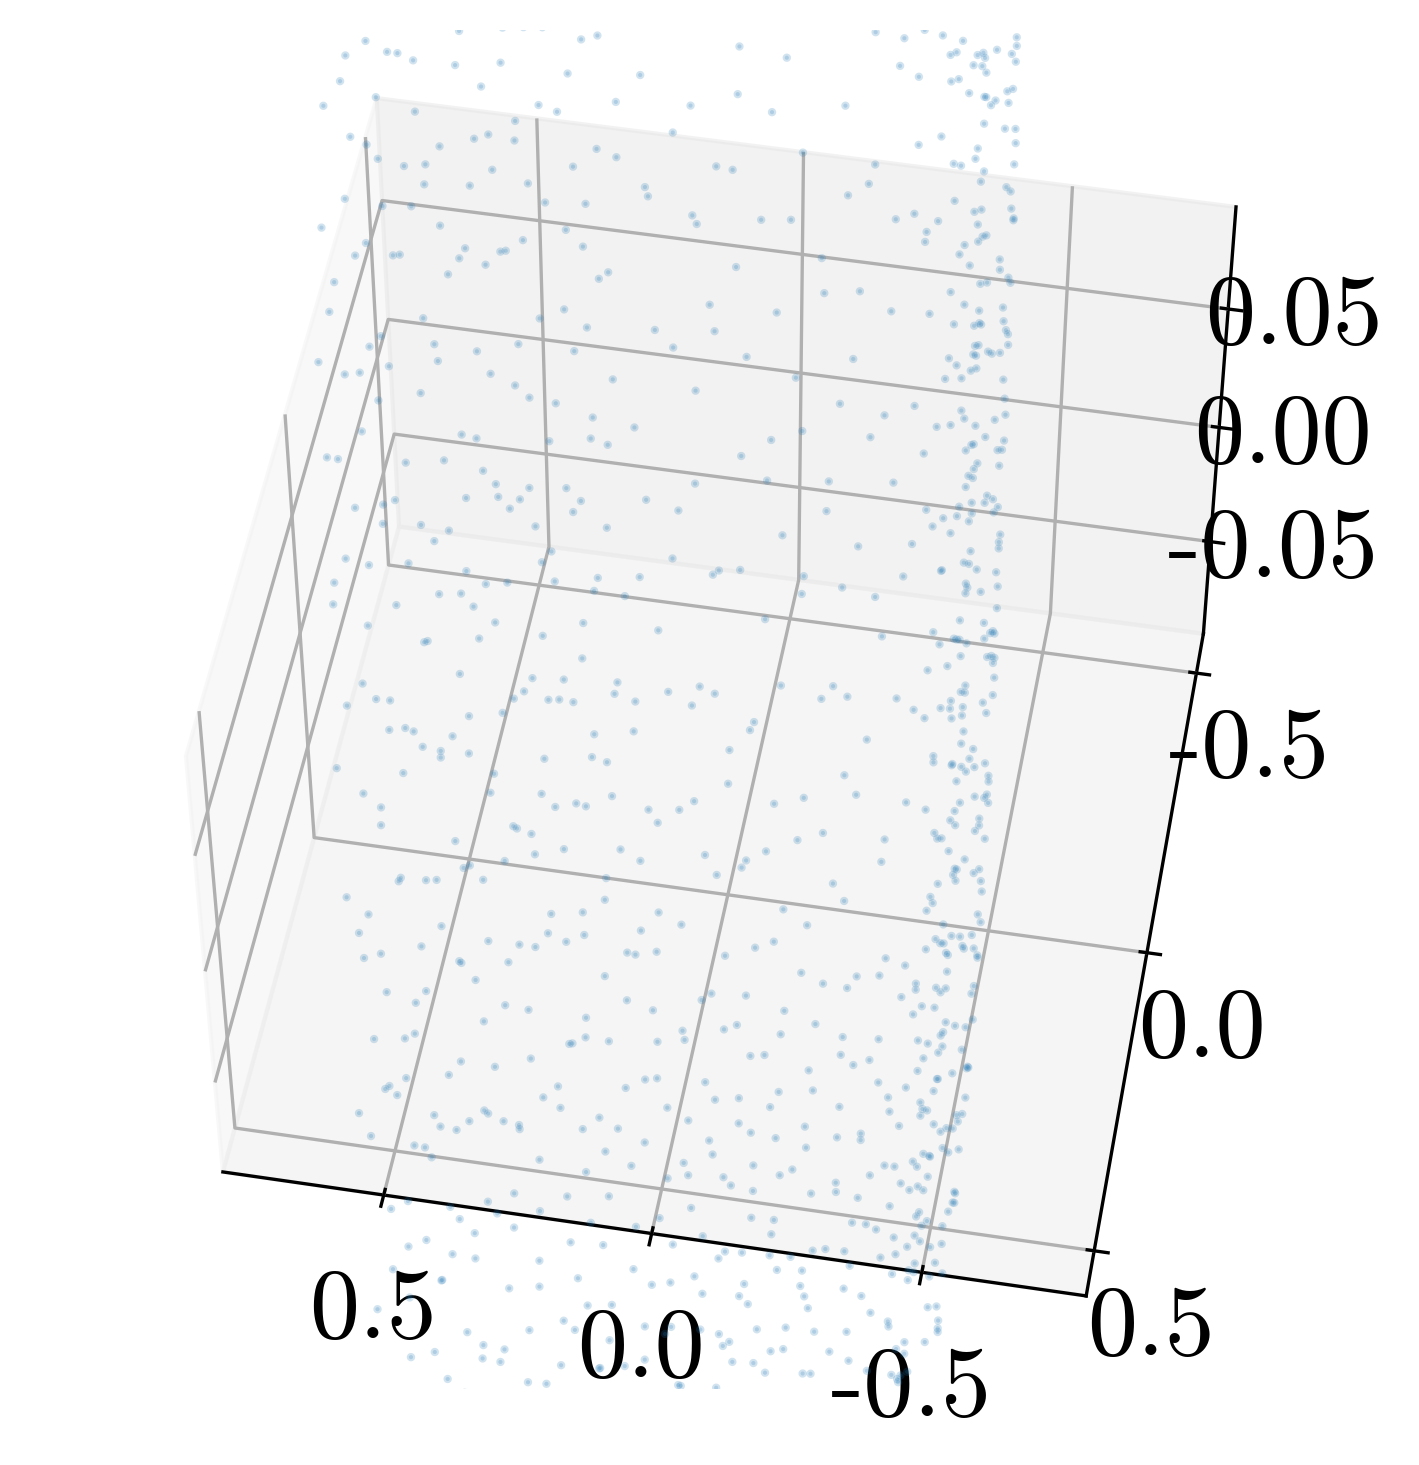

In [208]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.set_box_aspect([2,2,1])
#fig, ax = visualize_grid_torus(30,2,1)
#ax.scatter(data[:,0], data[:, 1], data[:,2], s=1, c=sc, cmap='viridis',zorder=10, alpha=0.5)
ax.scatter(data[:,0], data[:, 1],data[:,2], s=1, zorder=10, alpha=0.2)
ax.view_init(50, 100)
#ax.view_init(20, 100)
xminbound = -.7
xmaxbound = .7
yminbound = -.5
ymaxbound = .5
zminbound = -0.08
zmaxbound = 0.08
ax.auto_scale_xyz([xminbound, xmaxbound], [yminbound, ymaxbound], [zminbound, zmaxbound])

In [209]:
visualizer = np.zeros((npoints, 6))
visualizer[:,:3] = data
visualizer[:,3:] = killingfield*10
X, Y, Z, U, V, W = zip(*visualizer[np.random.choice(np.arange(0,npoints), 2000), :])

In [210]:
ax.quiver(X, Y, Z, U, V, W, color="C1", linewidth=0.6)

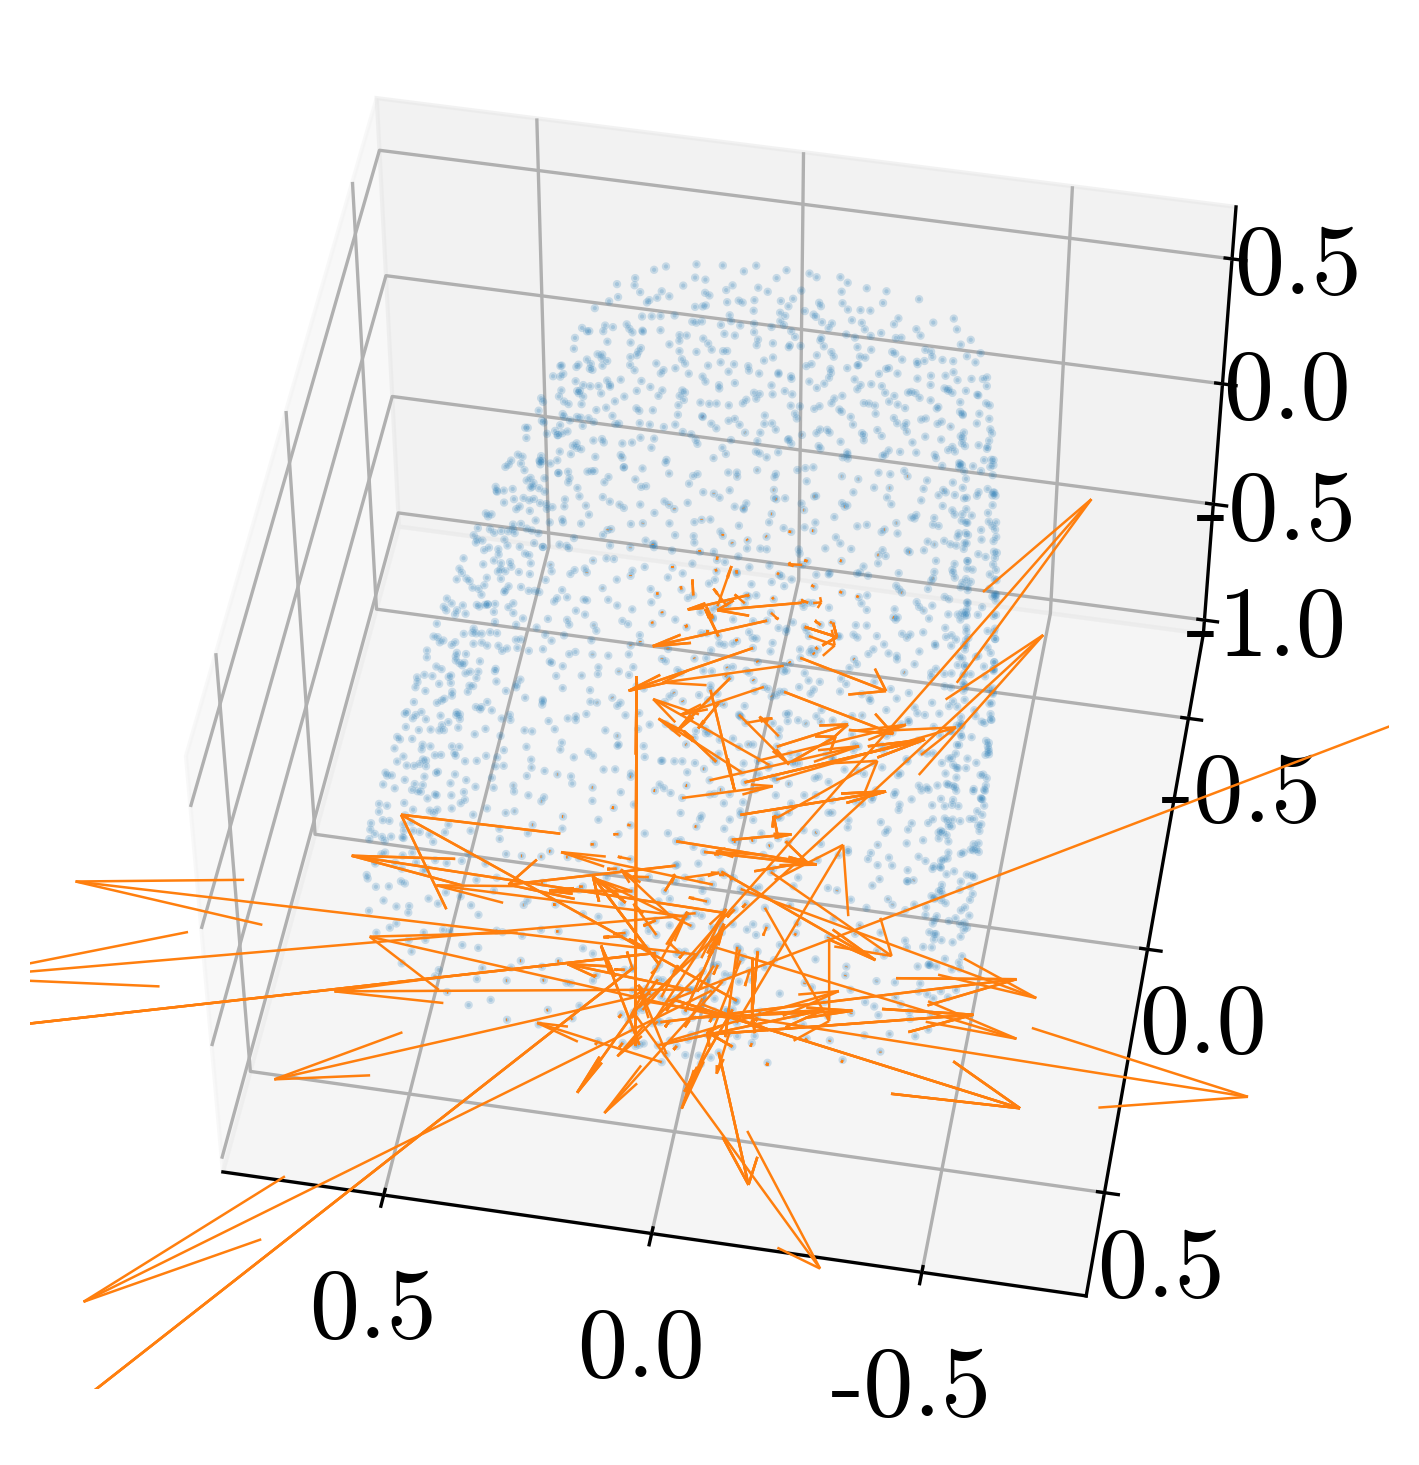

In [211]:
fig

In [217]:
visualizer = np.zeros((npoints, 6))
visualizer[:,:3] = data
visualizer[:,3:] = killingfield*3

In [218]:
visualizer[:,[1, 2]] = visualizer[:,[2, 1]]
visualizer[:,[4, 5]] = visualizer[:,[5, 4]]
X, Y, Z, U, V, W = zip(*visualizer[:])

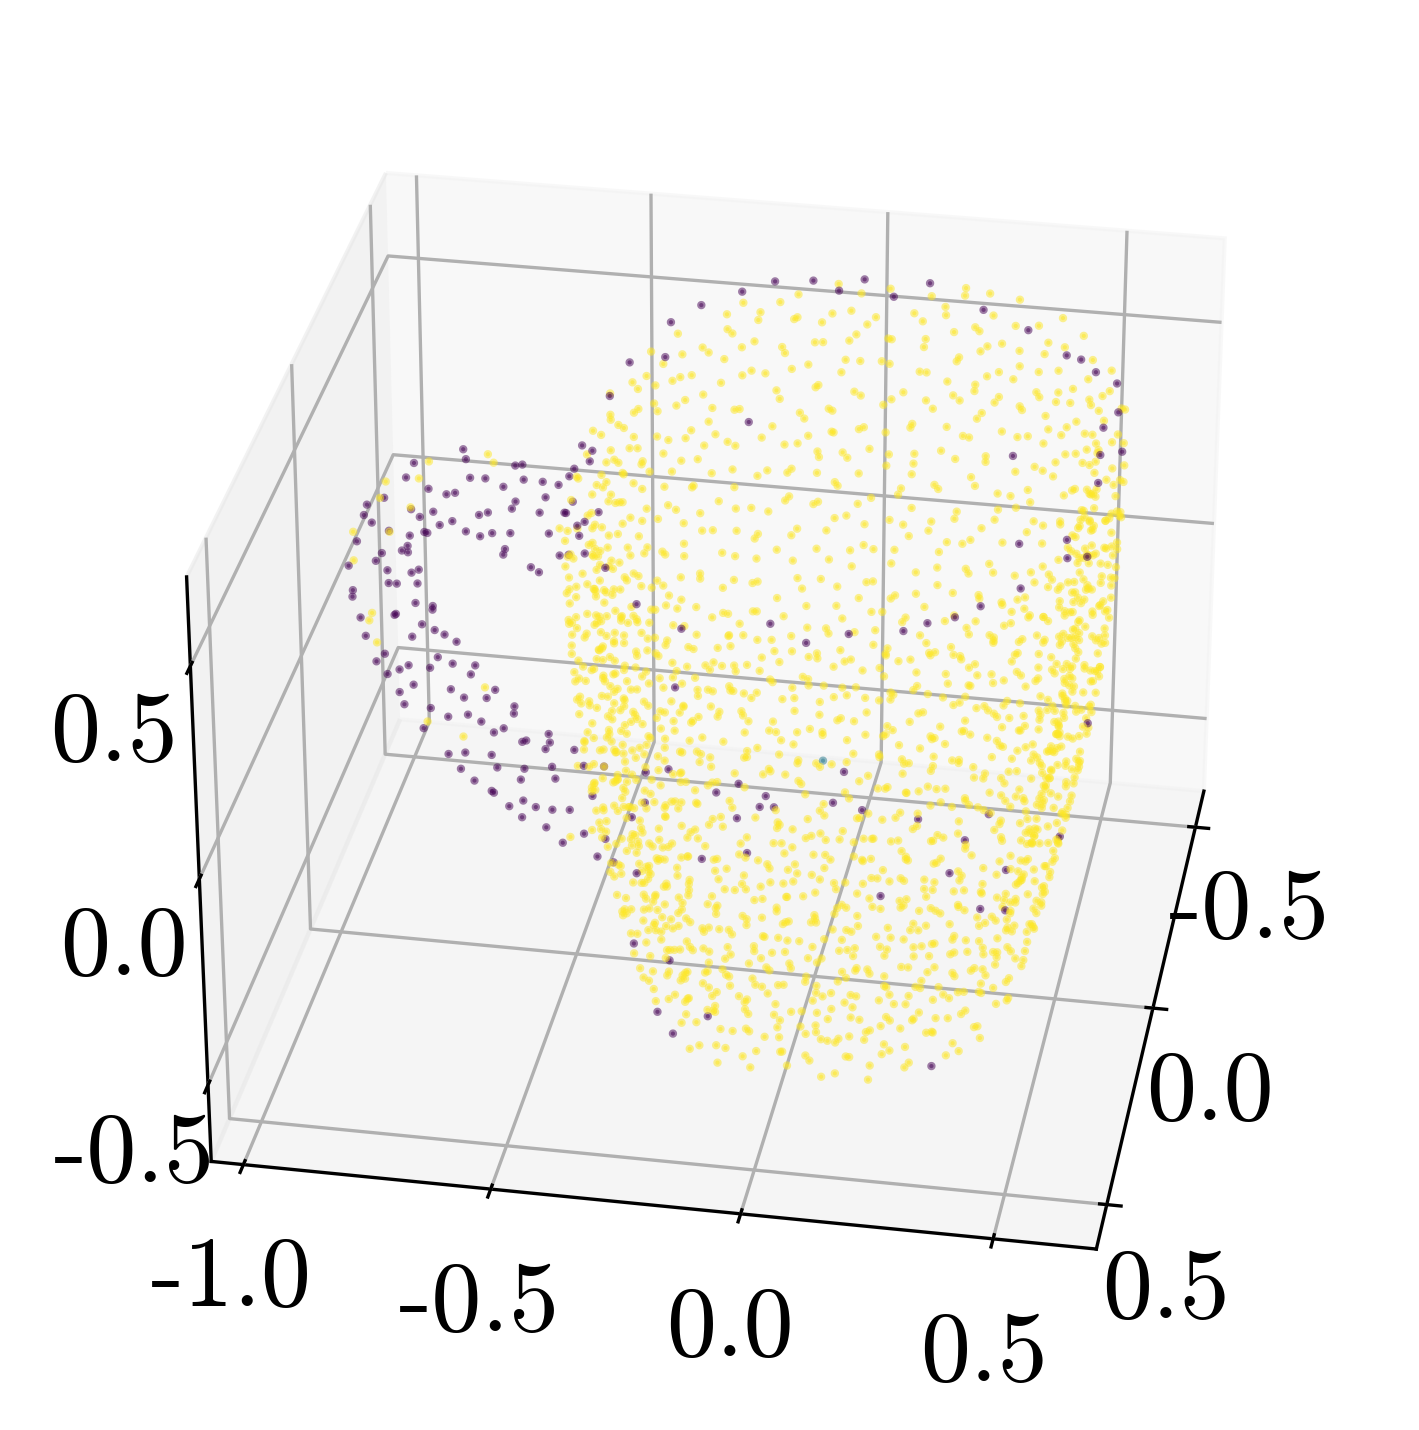

In [219]:
#fig, ax = visualize_grid_torus(30,3,1)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.set_box_aspect([2,2,1])
#fig, ax = visualize_grid_torus(30,2,1)
#ax.scatter(data[:,0], data[:, 1], data[:,2], s=1, c=sc, cmap='viridis',zorder=10, alpha=0.5)
#ax.scatter(data[:,0], data[:, 1], data[:,2], s=1, c=sc, cmap='viridis',zorder=10,norm = mpl.colors.Normalize(vmin=-1, vmax=0, clip=False), alpha=0.5)
#ax.view_init(60, 60)
#ax.view_init(20, 100)
ax.scatter(data[:,0], data[:, 2], data[:,1], s=1, c=sc, cmap='viridis',zorder=10,norm = mpl.colors.Normalize(vmin=-.2, vmax=.2, clip=False), alpha=0.5)
ax.view_init(30, 10)

In [220]:
ax.quiver(X, Y, Z, U, V, W, color="C0", linewidth=0.6)

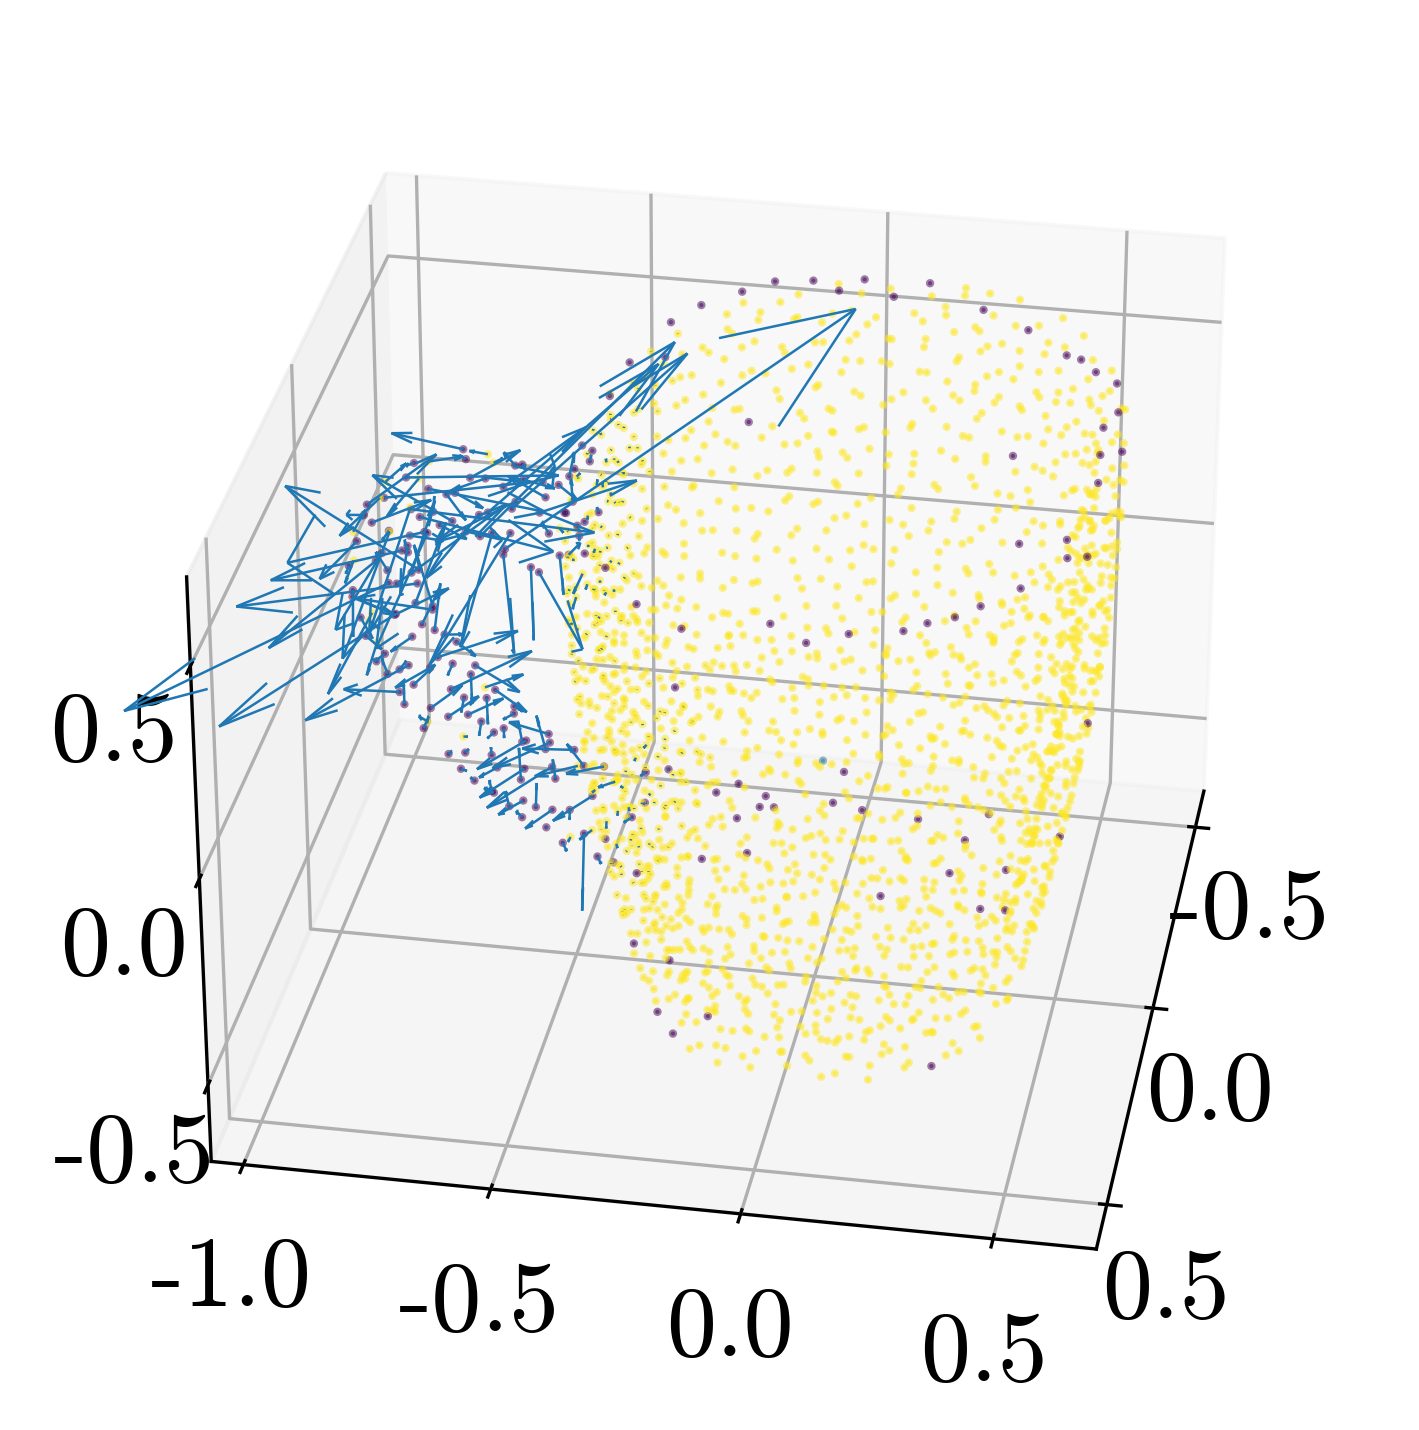

In [221]:
fig

In [143]:
show_tangents = np.zeros((npoints, 6))
show_tangents[:,:3] = data
show_tangents[:,3:] = tangents[:,0,:]

In [144]:
show_tangents2 = np.zeros((npoints, 6))
show_tangents2[:,:3] = data
show_tangents2[:,3:] = tangents[:,1,:]

In [145]:
tangents.shape

(5000, 2, 3)

In [146]:
killingfield.shape

(5000, 3)

In [147]:
X, Y, Z, U, V, W = zip(*show_tangents[:600])
X2, Y2, Z2, U2, V2, W2= zip(*show_tangents2[:100])

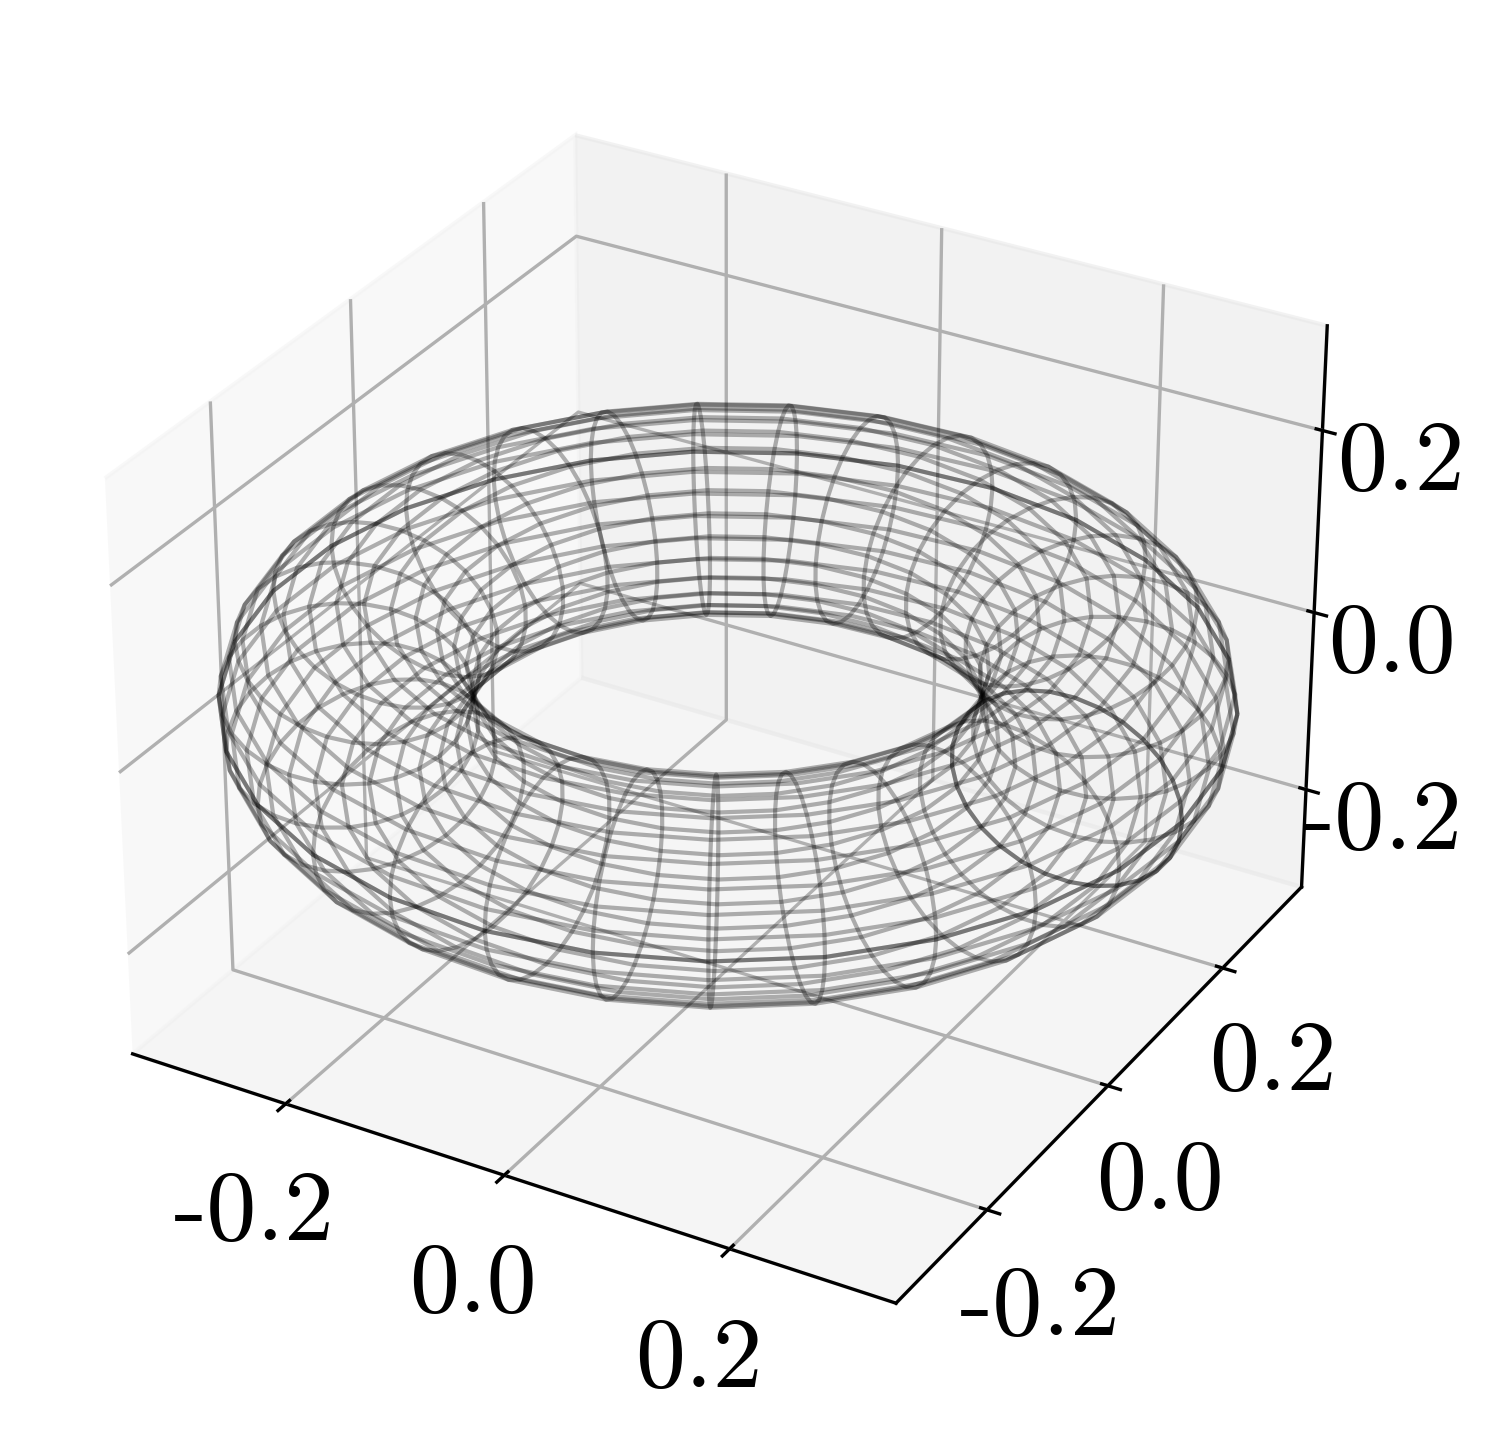

In [149]:
fig, ax = visualize_grid_torus(30,.3,.1)

In [150]:
ax.quiver(X, Y, Z, U, V, W, color="C0", linewidth=0.6)
#ax.quiver(X2, Y2, Z2, U2, V2, W2, color="C1", linewidth=0.6)

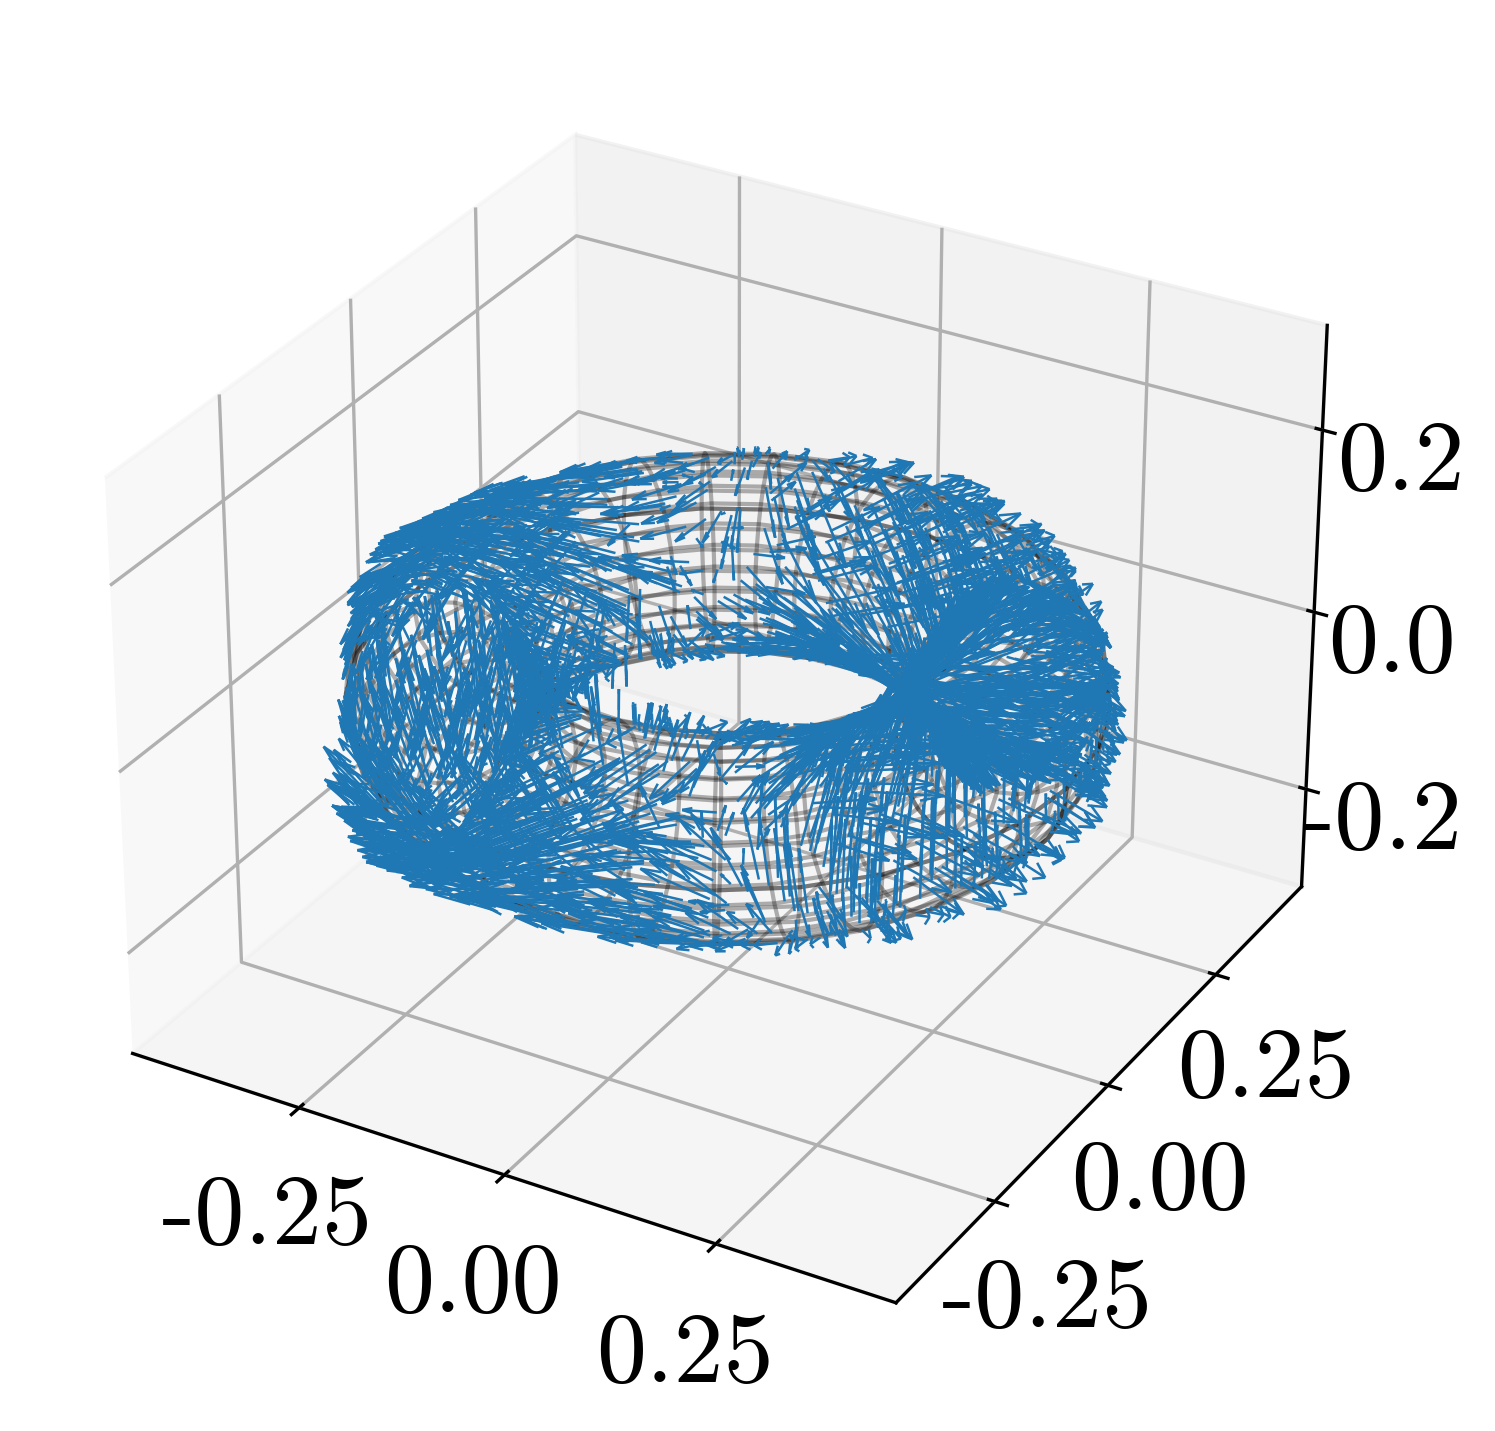

In [151]:
fig

In [29]:
npoints = 50000
n=4
k=20
data = sample_sphere(npoints, 2)
shape = data.shape
norm = np.sum(data**2, axis=1)
cols = np.meshgrid(np.arange(n), np.ones(k+1))[0]


In [39]:
npoints

50000

In [44]:
eps

0.001256748715664747

In [42]:
eps*npoints

62.83743578323735

In [40]:
npoints*eps**2

0.07897086671624957

In [45]:
(npoints)*(eps**2)*(1-(1/12)*eps**2)*(1/k)

0.003948542816112663

In [95]:
5/0.0123

406.5040650406504

In [34]:
epsilons = np.zeros(shape[0])
for i in range(0, shape[0], n):
    dot = data @ data[i:i+n].T
    dists = np.sqrt(np.abs(norm[:, None] - 2*dot + norm[i:i+n][None, :]))
    idx = np.argpartition(dists, k, axis=0)[:k+1]
    nbrs = idx[np.argsort(dists[idx, cols], axis=0), cols][1:]
    #print(dists.shape)
    #print(nbrs.shape)
    #print(nbrs[9,:])
    #print(dists[nbrs[9,:],np.arange(n)])
    #print(dists[nbrs[9,0],0])
    #print(dists[nbrs[9,1],1])
    #print(dists[nbrs[9,2],2])
    #print(dists[nbrs[9,3],3])
    epsilons[i:i+n] = dists[nbrs[k-1,:],np.arange(n)]

In [35]:
epsilons

array([0.00185067, 0.00101618, 0.00120442, ..., 0.00121097, 0.00104085,
       0.0021978 ])

In [36]:
eps = np.mean(epsilons)

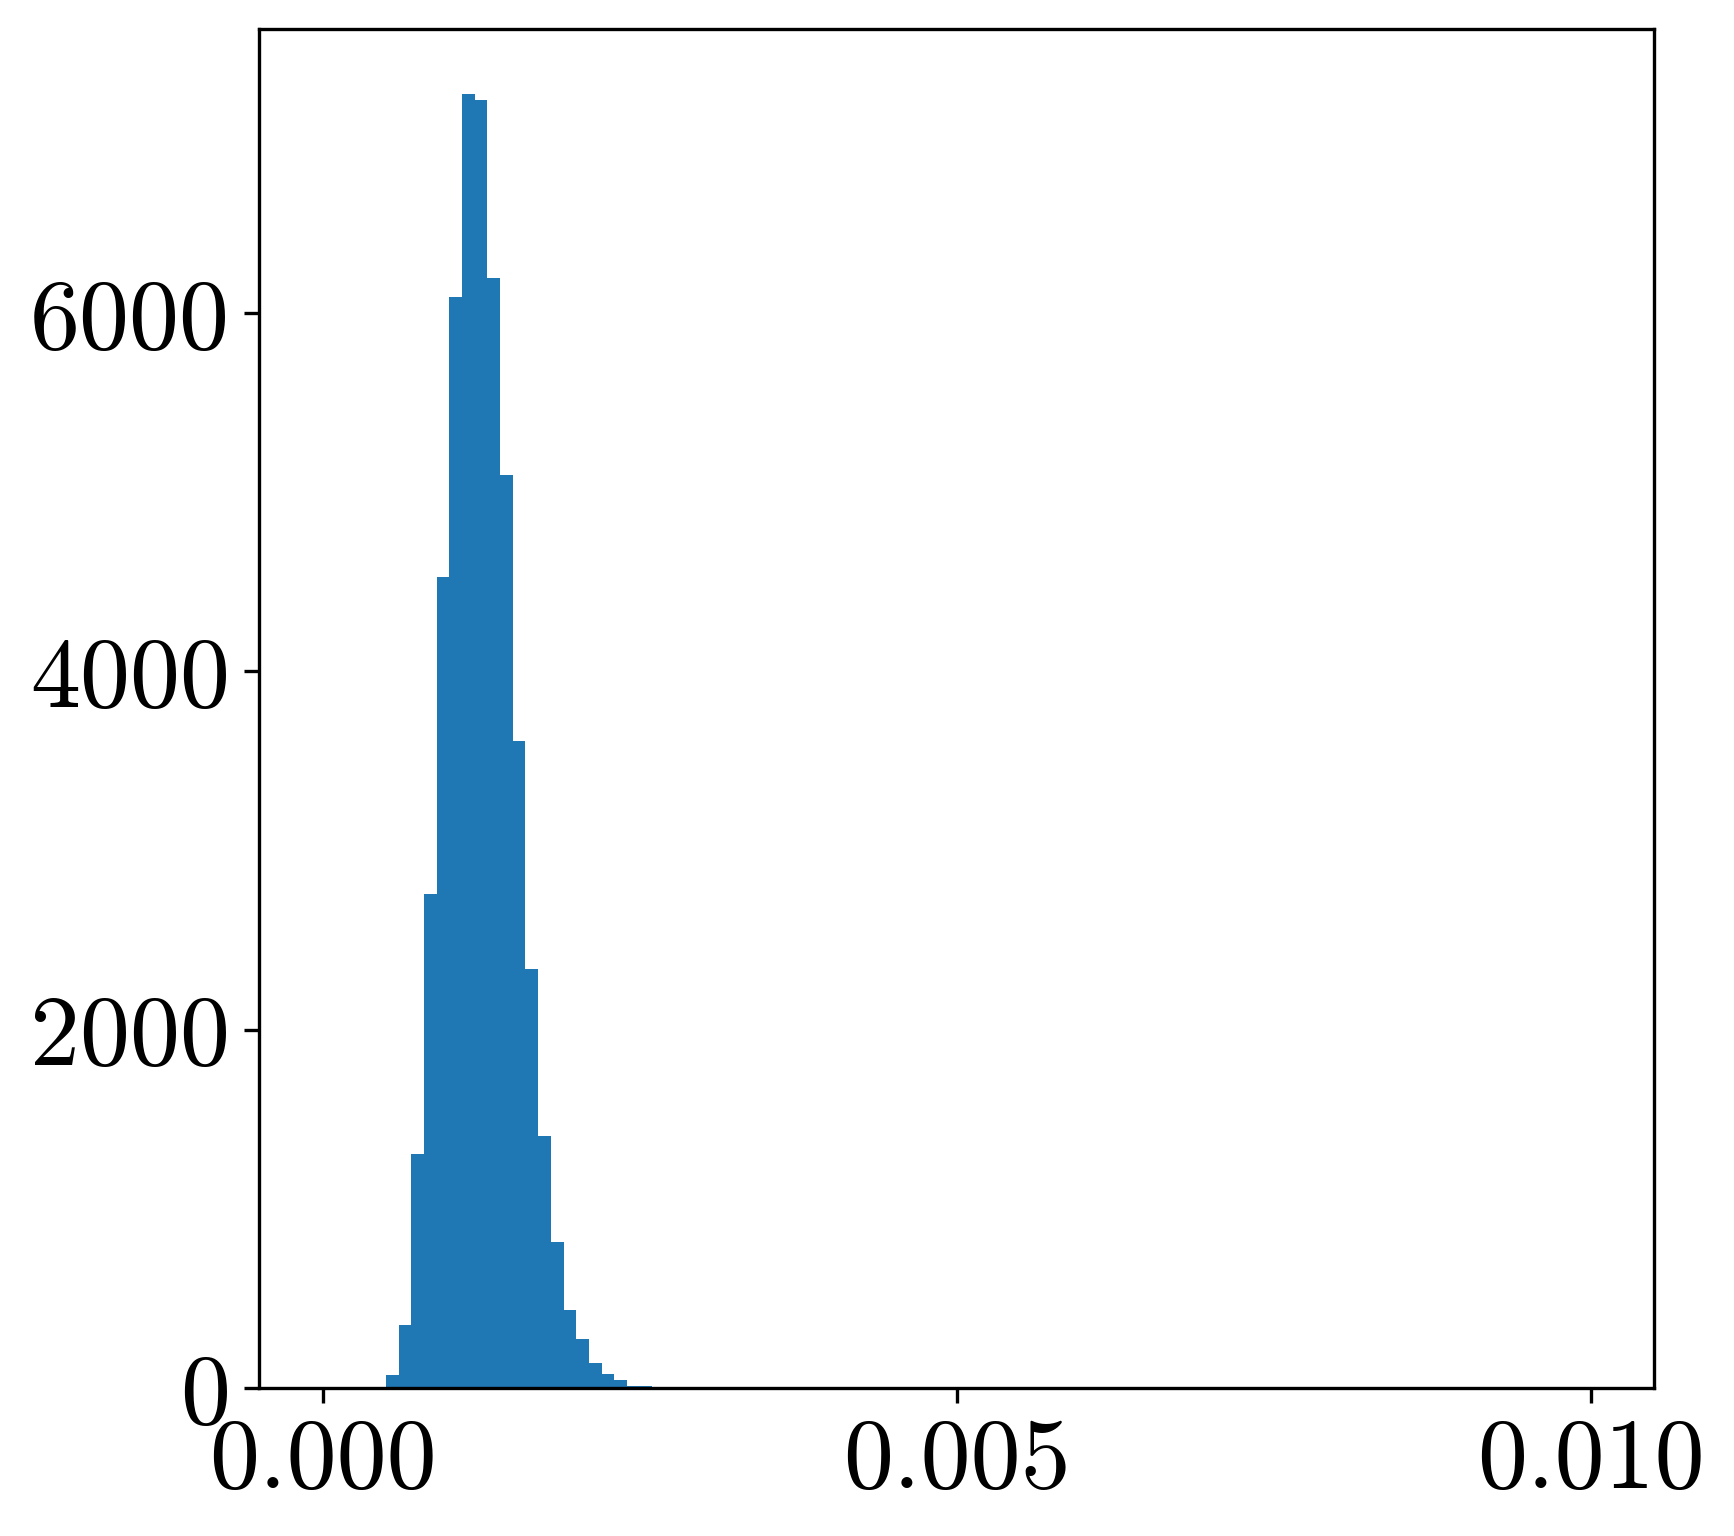

In [37]:
plt.hist(epsilons, bins=np.linspace(0,0.01,101));